In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from sklearn import preprocessing
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [157]:
from sklearn.utils import resample
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter 
from numpy import where
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

In [175]:
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks

In [3]:
import eli5
import shap
from IPython.display import HTML
import json
import altair as alt

import networkx as nx

Define Functions will be used for convenience 

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [8]:

def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc



In [9]:
def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True

In [10]:
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

Defining a function for modeling 

In [12]:
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=Logloss)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
          
        if model_type == 'xgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
    return result_dict

# setting up altair
#workaround = prepare_altair()
#HTML("".join((
#    "<script>",
#    workaround,
#    "</script>",
#)))

In [ ]:
The summary_table function will be used to inspect our data

In [13]:
def summary_table(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values   
    summary['Missing_Percentage'] = summary['Missing']*100/df.shape[0]
    summary['Missing_Percentage'] = round(summary['Missing_Percentage'], 2)
    summary['Uniques'] = df.nunique().values
    #summary['One_Value_Var'] = summary[summary['Uniques'] == 1]
    #summary['Min'] = df.min()
    #summary['Max'] = df.max()
    #summary['Scale'] = df.max() - df.min() 
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [14]:
def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

Loaing and processing data

In [15]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
#data souurce https://www.kaggle.com/c/ieee-fraud-detection/data


In [16]:
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)


Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


In [17]:
test_identity = reduce_mem_usage(test_identity)
test_transaction = reduce_mem_usage(test_transaction)

Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)


In [84]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [85]:
test.columns = test.columns.str.replace("-", "_")

In [87]:
#Inspect the categorical features
for col in train.columns:
    if train[col].dtype == 'object':       
        print(col)
        print(train[col].unique())


ProductCD
['W' 'H' 'C' 'S' 'R']
card4
['discover' 'mastercard' 'visa' 'american express' nan]
card6
['credit' 'debit' nan 'debit or credit' 'charge card']
P_emaildomain
[nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']
R_emaildomain
[nan 'gmail.com' 'ho

Possible Feature Engineering:
1. make a blacklist for email domains.
2. match if the email domains of senders and receivers are within the same jurisdiction
3. id30 and id31 appear to be phone system and brower respectively, can check whether the two variables are consistent
4. can also check the consistency between the DeviceInfo and id30/id31


In [88]:
summary_table(train)

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Missing_Percentage,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,0.000000000000000,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int8,0,0.000000000000000,2,0,0,0,0.220000000000000
2,TransactionDT,int32,0,0.000000000000000,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float16,0,0.000000000000000,8195,68.5,29,59,8.100000000000000
4,ProductCD,object,0,0.000000000000000,5,W,W,W,1.280000000000000
...,...,...,...,...,...,...,...,...,...
429,id_36,object,449555,76.129999999999995,2,NaN,NaN,NaN,0.280000000000000
430,id_37,object,449555,76.129999999999995,2,NaN,NaN,NaN,0.750000000000000
431,id_38,object,449555,76.129999999999995,2,NaN,NaN,NaN,1.000000000000000
432,DeviceType,object,449730,76.159999999999997,2,NaN,NaN,NaN,0.970000000000000


In [ ]:
del train_identity, train_transaction, test_identity, test_transaction

In [90]:
summary_table(test)

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Missing_Percentage,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,0.000000000000000,506691,3663549,3663550,3663551,18.949999999999999
1,TransactionDT,int32,0,0.000000000000000,494686,18403224,18403263,18403310,18.899999999999999
2,TransactionAmt,float16,0,0.000000000000000,7343,31.953125,49,171,7.930000000000000
3,ProductCD,object,0,0.000000000000000,5,W,W,W,1.370000000000000
4,card1,int16,0,0.000000000000000,13244,10409,4272,4476,9.949999999999999
...,...,...,...,...,...,...,...,...,...
428,id_36,object,369714,72.969999999999999,2,NaN,NaN,NaN,0.180000000000000
429,id_37,object,369714,72.969999999999999,2,NaN,NaN,NaN,0.790000000000000
430,id_38,object,369714,72.969999999999999,2,NaN,NaN,NaN,0.890000000000000
431,DeviceType,object,369760,72.980000000000004,2,NaN,NaN,NaN,0.990000000000000


Data Visualiztion for EDA

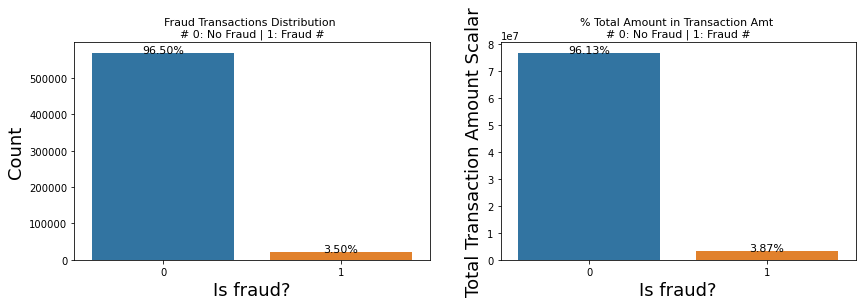

In [91]:
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(14,4))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=11)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=11) 

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=11)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=11) 
    
plt.show()    

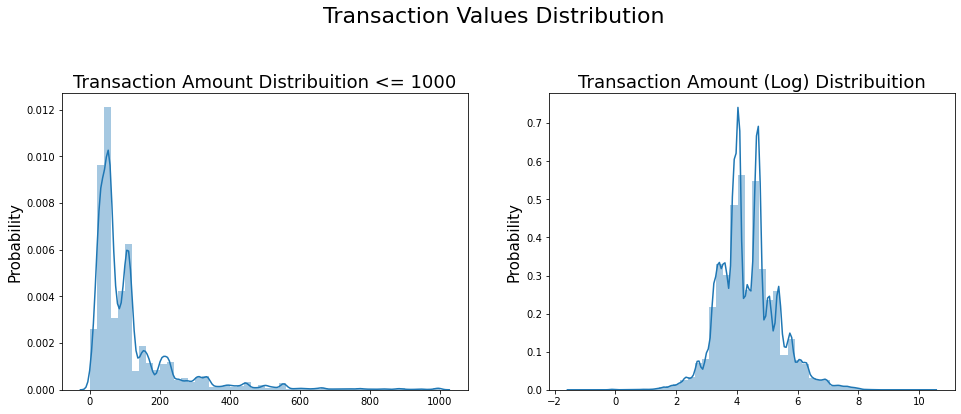

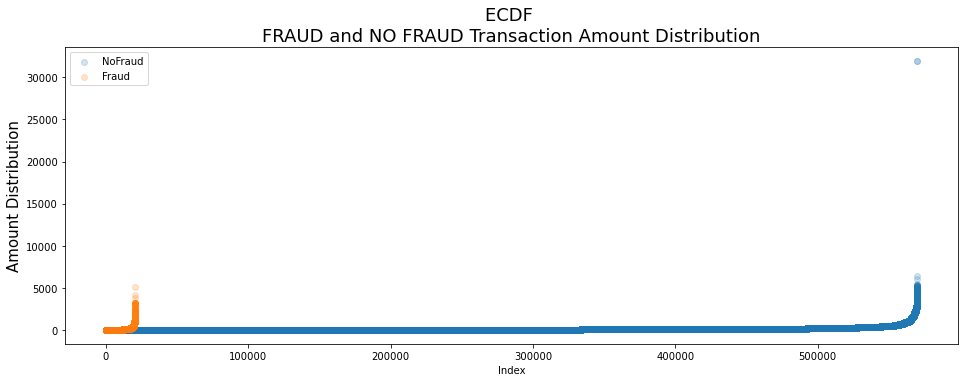

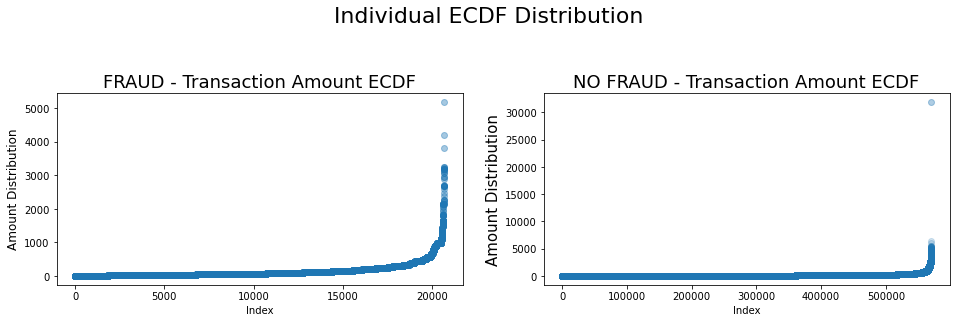

In [92]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(train[train['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(train['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
g4 = plt.scatter(range(train[train['isFraud'] == 0].shape[0]),
                 np.sort(train[train['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g4 = plt.scatter(range(train[train['isFraud'] == 1].shape[0]),
                 np.sort(train[train['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
g4= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
g = plt.scatter(range(train[train['isFraud'] == 1].shape[0]), 
                 np.sort(train[train['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(train[train['isFraud'] == 0].shape[0]),
                 np.sort(train[train['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g1= plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()


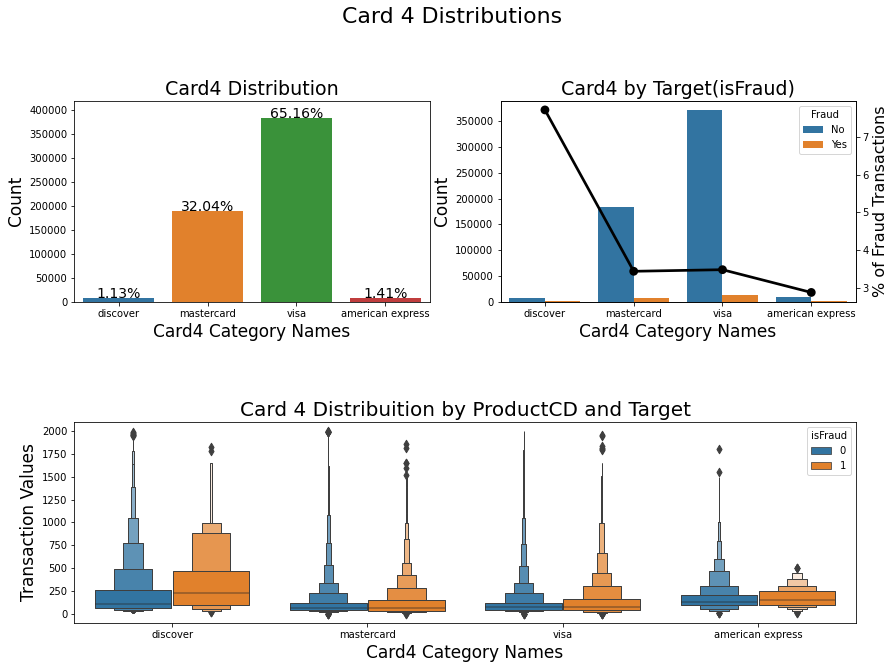

In [93]:
tmp = pd.crosstab(train['card4'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card4 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [94]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train[col] = train[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (train.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()


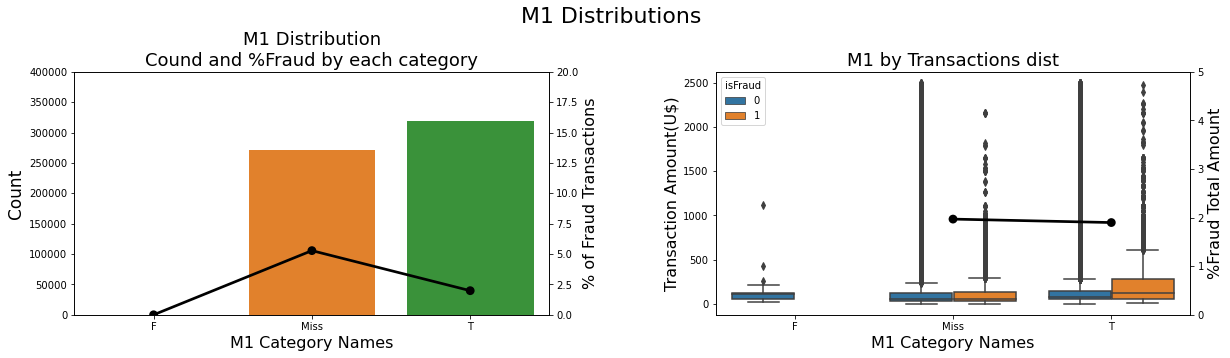

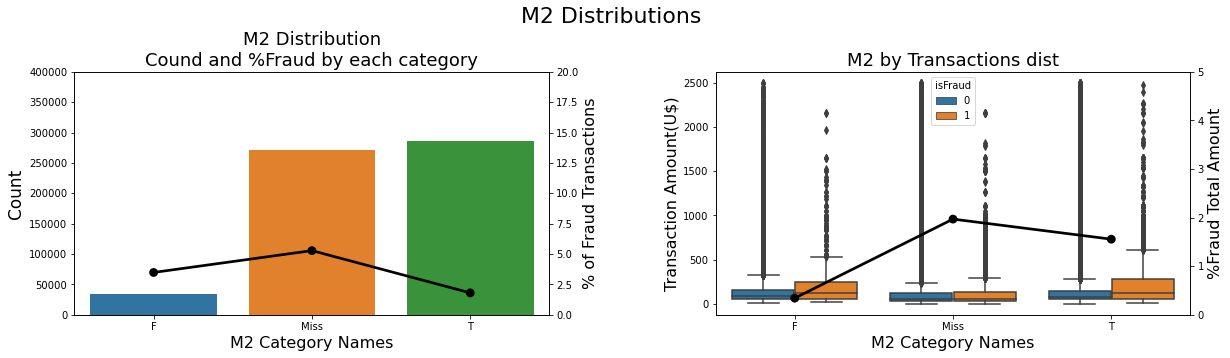

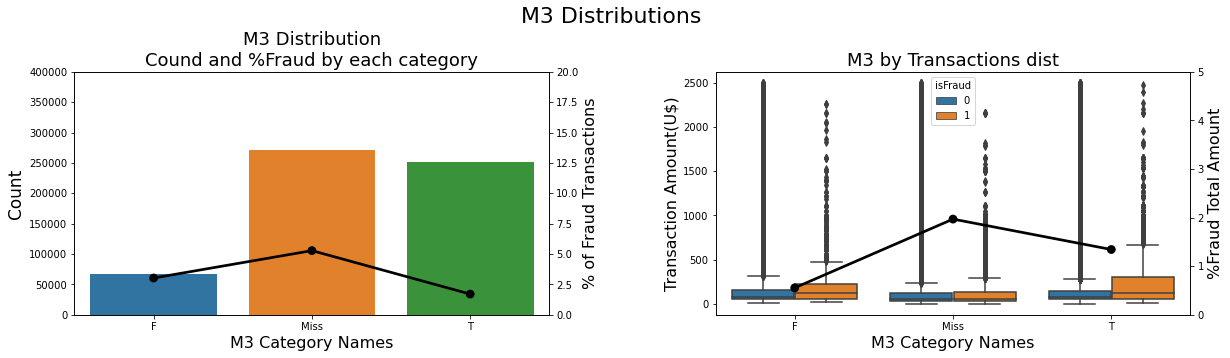

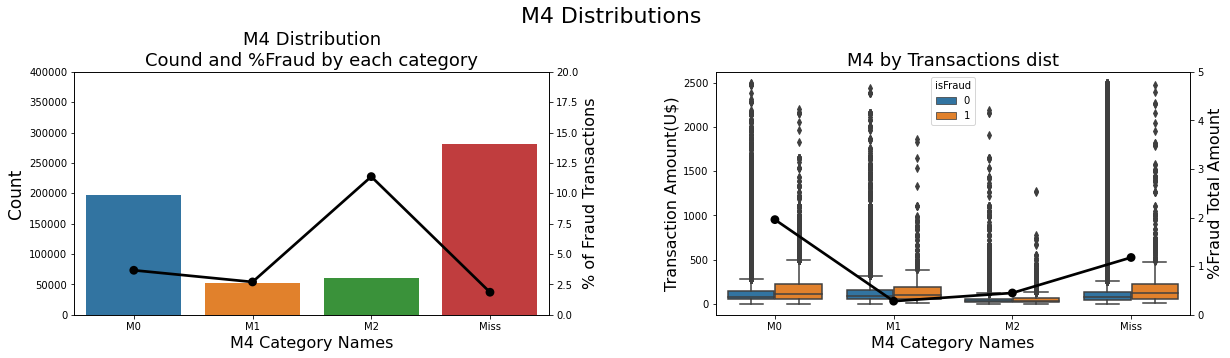

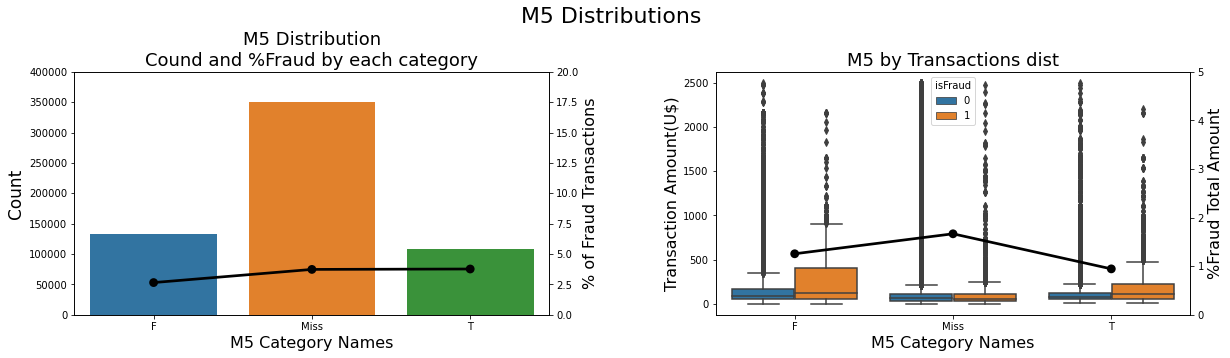

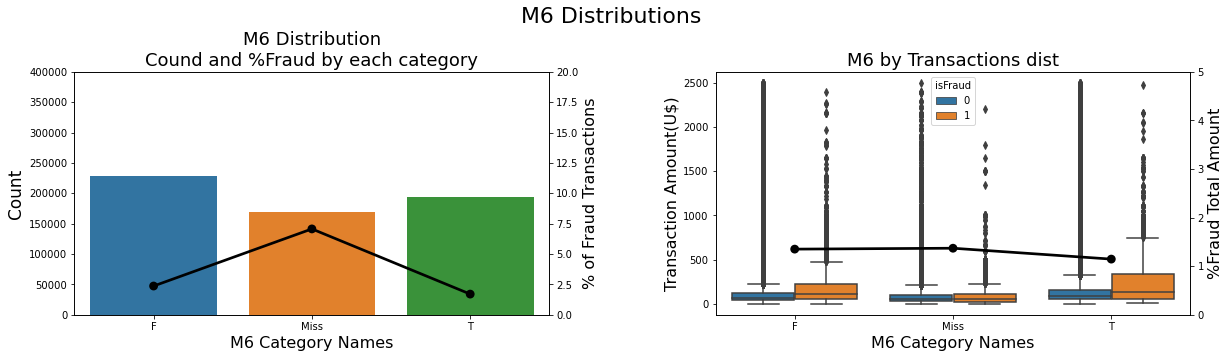

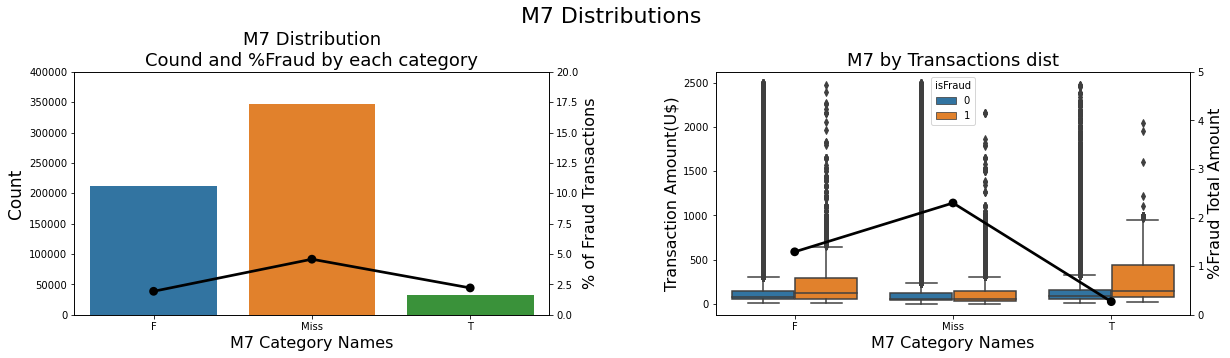

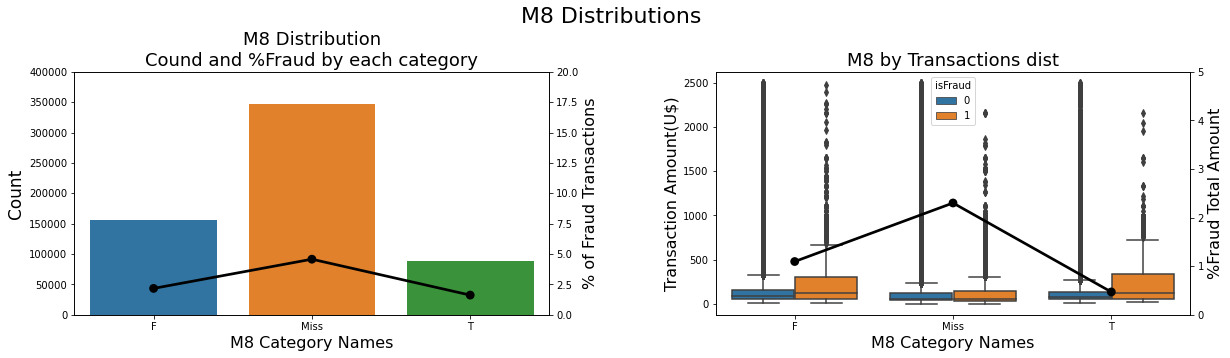

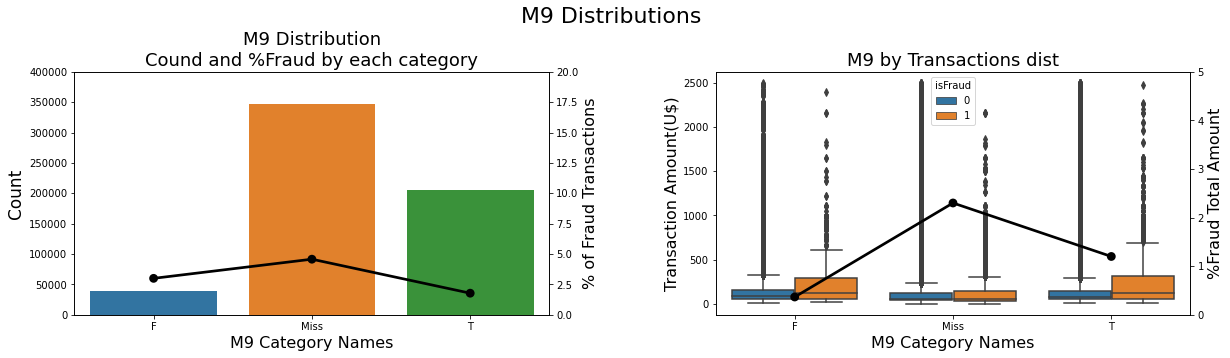

In [95]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train, col, lim=2500)

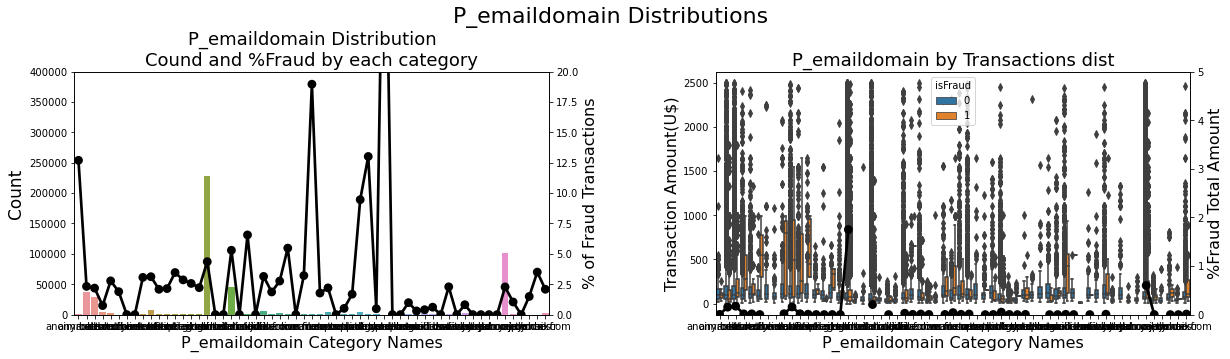

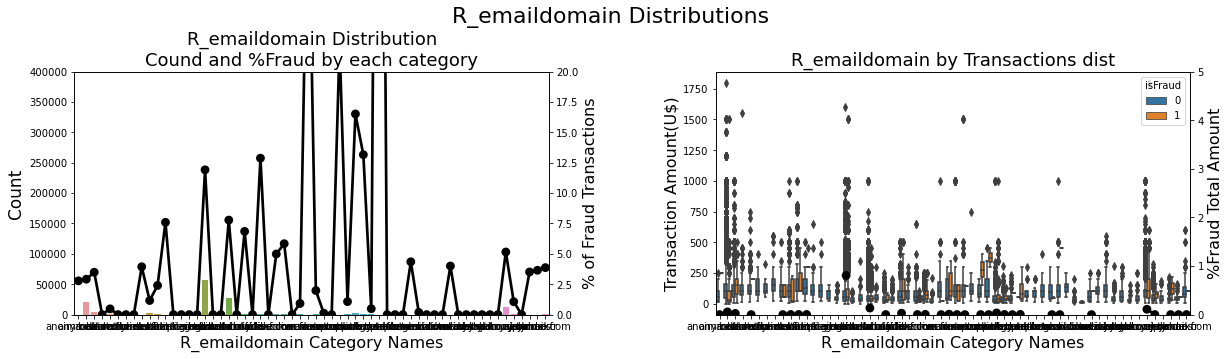

In [96]:
for col in ['P_emaildomain', 'R_emaildomain']:
    ploting_dist_ratio(train, col, lim=2500)

In [97]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    




In [98]:
train.loc[train['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train.loc[train['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train.loc[train['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train.loc[train.P_emaildomain.isin(train.P_emaildomain\
                                         .value_counts()[train.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train.P_emaildomain.fillna("NoInf", inplace=True)



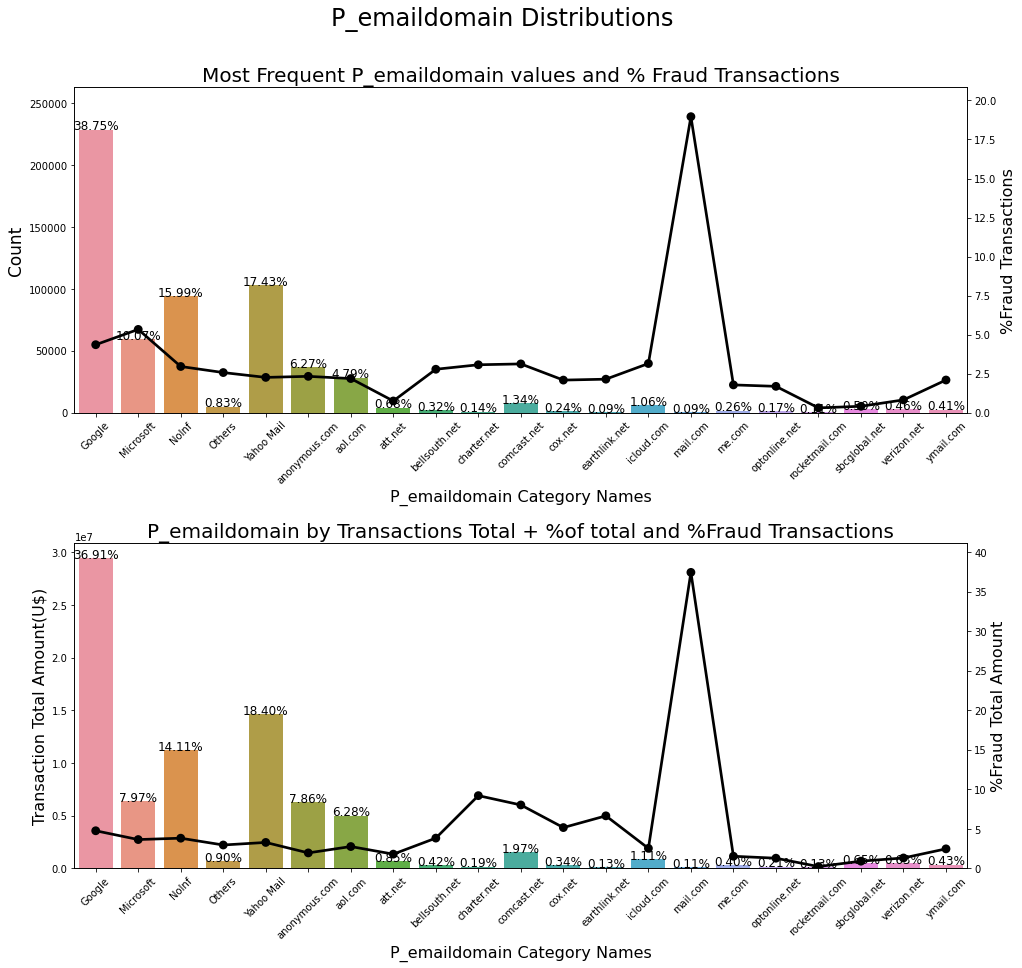

In [99]:
ploting_cnt_amt(train, 'P_emaildomain')

In [100]:
train['P_emaildomain']

0              NoInf
1             Google
2          Microsoft
3         Yahoo Mail
4             Google
             ...    
590535         NoInf
590536        Google
590537        Google
590538       aol.com
590539        Google
Name: P_emaildomain, Length: 590540, dtype: object

In [101]:
train.loc[train['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

train.loc[train['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
train.loc[train['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
train.loc[train.R_emaildomain.isin(train.R_emaildomain\
                                         .value_counts()[train.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
train.R_emaildomain.fillna("NoInf", inplace=True)

#ploting_cnt_amt(train, 'R_emaildomain')

In [102]:
train['R_emaildomain']

0         NoInf
1         NoInf
2         NoInf
3         NoInf
4         NoInf
          ...  
590535    NoInf
590536    NoInf
590537    NoInf
590538    NoInf
590539    NoInf
Name: R_emaildomain, Length: 590540, dtype: object

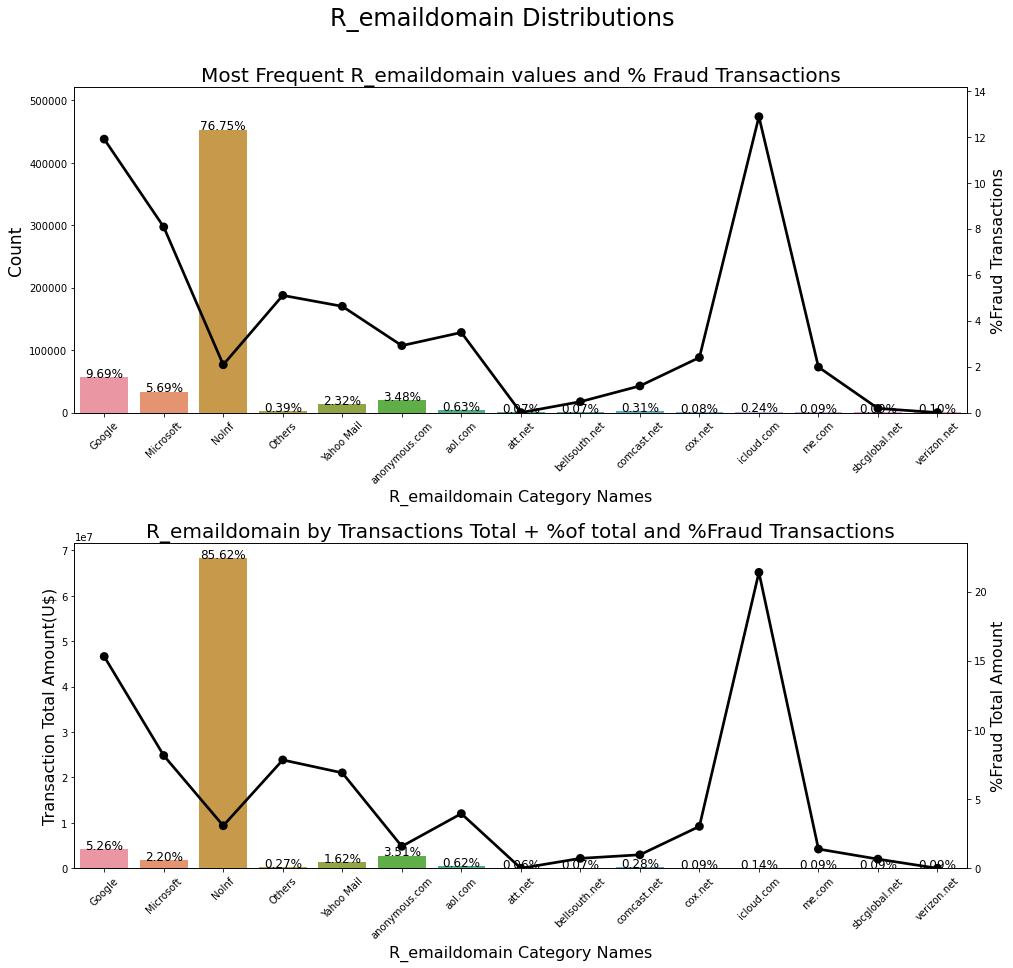

In [103]:
ploting_cnt_amt(train, 'R_emaildomain')

Feature Engineering 

In [105]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')
test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('std')



In [106]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [107]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)


82

In [108]:
#cols_to_drop

In [109]:
list1 = list(train.columns)


In [ ]:
check =  all(item in list1 for item in cols_to_drop)
 
if check is True:
    print("True")    
else :
    print("No, List1 doesn't have all elements of the List2.")

Drop the features with extre values, too many missing values (missing values percentage greater than 90%, and only one value)

In [111]:
train_1 = train.drop(cols_to_drop, axis=1)
test_1 = test.drop(cols_to_drop, axis=1)

In [115]:
train_1['TransactionAmt'] = np.log(train_1['TransactionAmt'])
test_1['TransactionAmt'] = np.log(test_1['TransactionAmt'])

Encoding categorical features

In [112]:
for col in train_1.columns:
    if train_1[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_1[col].astype(str).values) + list(test_1[col].astype(str).values))
        train_1[col] = le.transform(list(train_1[col].astype(str).values))
        test_1[col] = le.transform(list(test_1[col].astype(str).values))  
        
      

Prepare data for modeling (Supervised Learning)

(Note the modeling below is based on only the "train" data set, since the label for the test data set is unkonwn. 

I will use the test data set for semi-supervised learning and unsupervised learning. )

In [125]:
X = train_1.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train_1.sort_values('TransactionDT')['isFraud']



In [131]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )

In [134]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X)
X = imputer.transform(X)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
counter = Counter(y_train)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_train == label)[0]
	plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))
plt.legend()
plt.show()

Resampling 

In this section, I will try different re-sampling methods to see how they perform

In [161]:
# SMOTE Oversampling
sm = SMOTE()
X_train_0, y_train_0 = sm.fit_sample(X_train, y_train)

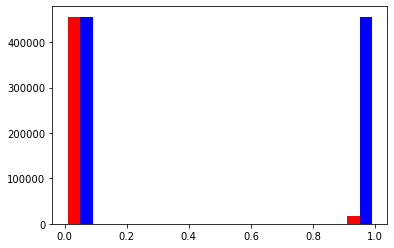

In [165]:
plt.hist([y_train, y_train_0], color = ['r','b'])

plt.show()

Counter({0: 455886, 1: 455886})


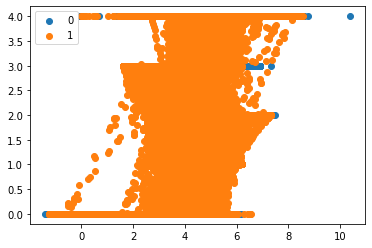

In [166]:
counter = Counter(y_train_0)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_train_0 == label)[0]
	plt.scatter(X_train_0[row_ix, 0], X_train_0[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [167]:
borderline_sm = BorderlineSMOTE()
X_train_1, y_train_1 = borderline_sm.fit_resample(X_train, y_train)

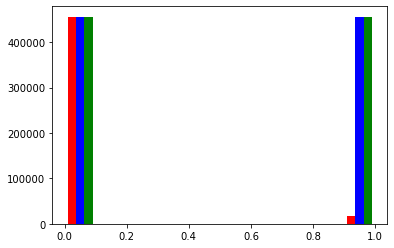

In [168]:
plt.hist([y_train, y_train_0, y_train_1], color = ['r','b', 'g'])

plt.show()

Counter({0: 455886, 1: 455886})


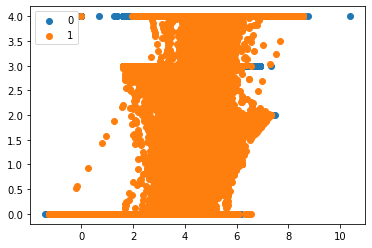

In [169]:
counter = Counter(y_train_1)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_train_1 == label)[0]
	plt.scatter(X_train_1[row_ix, 0], X_train_1[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [170]:
adasyn = ADASYN()
X_train_2, y_train_2 = adasyn.fit_resample(X_train, y_train)

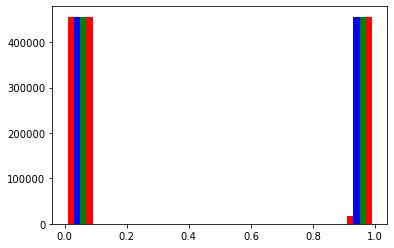

In [173]:
plt.hist([y_train, y_train_0, y_train_1, y_train_2], color = ['r','b', 'g', 'r'])

plt.show()

Counter({0: 455886, 1: 455753})


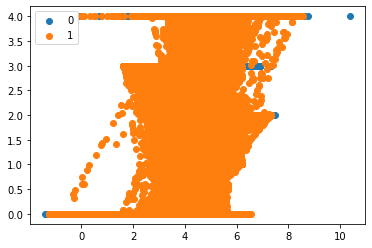

In [174]:
counter = Counter(y_train_2)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_train_2 == label)[0]
	plt.scatter(X_train_2[row_ix, 0], X_train_2[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [177]:
NM1 = NearMiss(version=1, n_neighbors_ver3=3)
NM2 = NearMiss(version=2, n_neighbors_ver3=3)
NM3 = NearMiss(version=3, n_neighbors_ver3=3)
CNN = CondensedNearestNeighbour(n_neighbors=1)
TM = TomekLinks()
X_train_3, y_train_3 = NM1.fit_resample(X_train, y_train)
#X_train_4, y_train_4 = NM2.fit_resample(X_train, y_train)
#X_train_5, y_train_5 = NM3.fit_resample(X_train, y_train)
#X_train_6, y_train_6 = CNN.fit_resample(X_train, y_train)
#X_train_7, y_train_7 = TM.fit_resample(X_train, y_train)

MemoryError: Unable to allocate 56.2 GiB for an array with shape (455886, 16546) and data type float64

Hybrid Resampling 

In [ ]:
X_train_8, y_train_8 = CNN.fit_resample(X_train_0, y_train_0)


In [ ]:
X_train_9, y_train_9 = TM.fit_resample(X_train_0, y_train_0)

In [ ]:
plt.hist([y_train, y_train_3, y_train_8, y_train_9], color = ['r','b', 'g', 'r'])

plt.show()

In [114]:
train_1.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2
count,5.905400000000000e+05,590540.000000000000000,5.905400000000000e+05,590540.000000000000000,590540.000000000000000,590540.000000000000000,581607.0,588975.0,590540.000000000000000,586281.0,...,137682.000000000000000,140689.000000000000000,495856.000000000000,499873.00000000000,4.950340000000000e+05,499873.000000000000000,439461.000000000000,439651.000000000000,4.394410000000000e+05,439649.000000000000000
mean,3.282269500000000e+06,0.034990009144173,7.372311310116165e+06,135.027347405866749,3.220757273004369,9898.734658109526208,NaN,NaN,3.266305415382531,NaN,...,2.274893243462171,1.100168836455091,NaN,NaN,inf,0.808159298359254,NaN,NaN,inf,0.880730334656396
std,1.704743583204291e+05,0.183754634178414,4.617223646539679e+06,239.157437904269983,1.423926237922079,4901.170153494897932,NaN,0.0,1.035866449536985,0.0,...,211.568183836337113,1.000589732525366,0.000000000000,0.00000000000,NaN,1.000329218868863,0.000000000000,0.000000000000,NaN,1.000847277691198
min,2.987000000000000e+06,0.000000000000000,8.640000000000000e+04,0.250976562500000,0.000000000000000,1000.000000000000000,100.0,100.0,0.000000000000000,100.0,...,0.000008502891341,0.000008183255711,-2.281250000000,-0.53857421875,-7.270107265580703e-01,-0.417536341775469,-0.301513671875,-0.327880859375,-2.872467370493161e-01,-0.289952277137225
25%,3.134634750000000e+06,0.000000000000000,3.027057750000000e+06,43.312500000000000,3.000000000000000,6019.000000000000000,214.0,150.0,2.000000000000000,166.0,...,0.556269599227806,0.433471587214985,0.000000000000,0.00000000000,0.000000000000000e+00,0.000000000000000,0.000000000000,0.000000000000,0.000000000000000e+00,0.000000000000000
50%,3.282269500000000e+06,0.000000000000000,7.306527500000000e+06,68.750000000000000,4.000000000000000,9678.000000000000000,361.0,150.0,4.000000000000000,226.0,...,1.014719828729572,0.799022335555993,0.387451171875,0.31982421875,3.245605892540059e-01,0.256558475066854,0.459472656250,0.458984375000,4.087180504092913e-01,0.405933187992115
75%,3.429904250000000e+06,0.000000000000000,1.124662000000000e+07,125.000000000000000,4.000000000000000,14184.000000000000000,512.0,150.0,4.000000000000000,226.0,...,1.792342666656483,1.436768588323323,1.647460937500,1.91894531250,1.774350663776357e+00,1.549411967070413,1.910156250000,1.928710937500,1.707857567781682e+00,1.705885897157342
max,3.577539000000000e+06,1.000000000000000,1.581113100000000e+07,31936.000000000000000,4.000000000000000,18396.000000000000000,600.0,231.0,4.000000000000000,237.0,...,55460.859722195069480,8.167004913953207,56.875000000000,6.29687500000,inf,4.442438166552162,31.250000000000,24.218750000000,inf,6.129192934257170


In [176]:
X_train_list = ['X_train', 'X_train_0', 'X_train_1', 'X_train_2', 'X_train_3', 'X_train_4']
y_train_list = ['y_train', 'y_train_0', 'y_train_1', 'y_train_2', 'y_train_3', 'y_train_4']

In [177]:
n_fold = 3
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

Fold 1 started at Fri Dec 18 22:07:32 2020
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.993899	training's auc: 0.993899	valid_1's auc: 0.915413	valid_1's auc: 0.915413
Early stopping, best iteration is:
[493]	training's auc: 0.993748	training's auc: 0.993748	valid_1's auc: 0.915618	valid_1's auc: 0.915618
Fold 2 started at Fri Dec 18 23:04:29 2020
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.994591	training's auc: 0.994591	valid_1's auc: 0.930408	valid_1's auc: 0.930408
Early stopping, best iteration is:
[690]	training's auc: 0.997639	training's auc: 0.997639	valid_1's auc: 0.931087	valid_1's auc: 0.931087
Fold 3 started at Sat Dec 19 00:14:09 2020
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.994856	training's auc: 0.994856	valid_1's auc: 0.927146	valid_1's auc: 0.927146
Early stopping, best iteration is:
[399]	training's auc: 0.992026	training's auc: 0.992026	vali

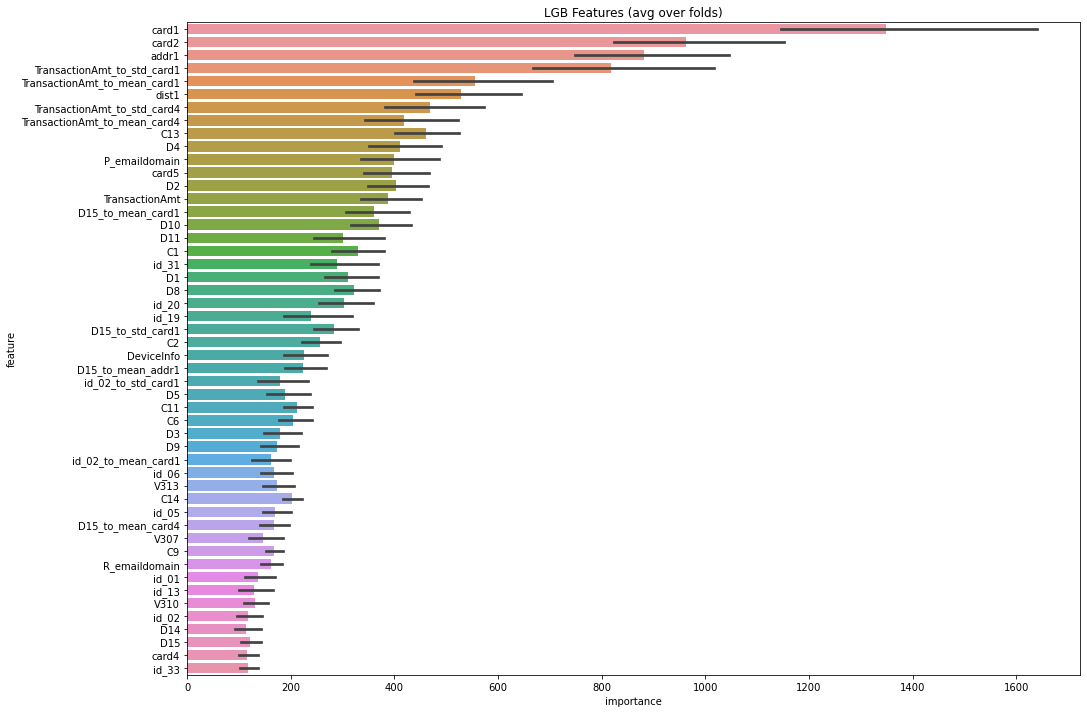

In [178]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
# try Lgb
for X in X_train_list:
    for y in y_train_list:
        result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [1]:
# Try XGB
result_dict_xgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='xgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

NameError: name 'train_model_classification' is not defined

In [ ]:
# Try CAT
result_dict_cat = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='cat', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [ ]:
# Try sklearn
models = ['', '', '',]
for model in models:
    result_dict_skl = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='sklearn', model = model, eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

Hyperprameter Tunning 

In [ ]:
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(sample_submission.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)

space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    
    
     # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}

Unsupervised Learning 

Predict The Fraudulent Transactions by Anamoly Detection

Semi Supervised Learning 